In [1]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



/Users/RuiCheng/anaconda/envs/cs155/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [78]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,736.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>=747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>=747)&(wlGrid_<756),:]
l1.close()



In [3]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(500,1000,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [4]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_)
SIF_shape = f(wlGrid)
f1.close()

In [5]:
spectra = np.mean(spectra_[100,:,500:600],axis=-1)
print(spectra_.shape)

(256, 501, 1432)


In [6]:
co = 2.355

class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [9]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [79]:


    
def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    b.FWHM = x[3]
    print(b.FWHM)
    poly = x[-4:-1]
    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

    Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.median(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
        dx = [.5e-6,1e-6,1e-6,1e-4]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
            
        FWHM2=b.FWHM+dx[3]
        Lo_conv = gaussian_filter1d(Lo,FWHM2/b.res/co)
        
        finter1_FWHM = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted = finter1_FWHM(wl_shifted)

        finter2_FWHM = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_FWHM = finter2_FWHM (b.wl_out)# output Lo
        F_ref_nosif = Lo_1_FWHM*np.polyval(poly,dwl)
        F_forward_FWHM = F_ref_nosif+a*SIF_shape
        K[:,3] = (F_forward_FWHM-F_forward)/dx[3]
        
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
        #F0,K = forward_model_shift(x,b,compK=True)
        Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
        x_plus1 = x+ Gain.dot(F-F0)
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [80]:
F_forward,K = forward_model_shift([0,1,40,0.07]+[0.133,0.3,233,0.06],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(F_forward)

0.07


In [81]:
x_linear

array([-1.01135734e-18,  3.69496100e-15, -1.84563476e-12,  4.45421477e-13,
        1.33000000e-01,  3.00000000e-01,  2.33000000e+02,  6.00000000e-02])

Text(0.5,1,'linear retrievel one step')

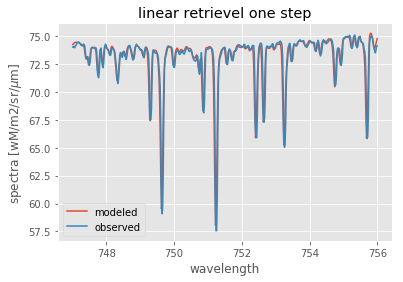

In [82]:
plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'F_forward-F_observed')

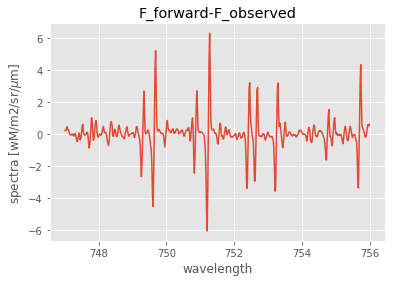

In [83]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

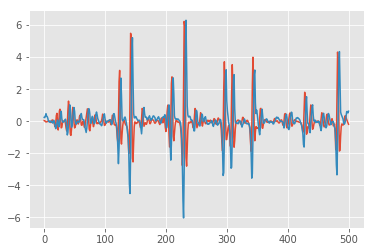

In [84]:
plt.plot(K[:,3])
plt.plot(F_forward-spectra)

In [85]:
ma


NameError: name 'ma' is not defined

In [87]:
ma,mb,mc = iterate_fit([0,1,40,0.7]+[0.133,0.3,233,0.06],mySetup,spectra,n_itr=200,thrs=1e-12)

0.7
0.07070450569029973
0.4693185215499358
-0.01147732902008941


RuntimeError: no filter weights given

In [24]:
len(ma)

NameError: name 'ma' is not defined

In [617]:
np.array(ma)[:,-1]

array([-2.51839595, -2.72110706, -2.75413224, -2.77108936, -2.76937835,
       -2.76939893, -2.76942687, -2.76943369, -2.76943571, -2.76943629,
       -2.76943645, -2.7694365 , -2.76943651, -2.76943651, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943651,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943651,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76943652,
       -2.76943652, -2.76943652, -2.76943652, -2.76943652, -2.76

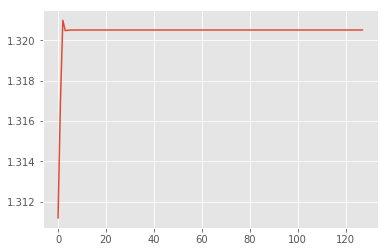

In [618]:
plt.plot(mc)

In [619]:
ma

[array([ 1.10781368e-07,  9.99231947e-01,  3.06317567e+01,  1.12399718e-01,
         5.12964701e-02,  2.40856739e+02, -2.51839595e+00]),
 array([ 1.53152326e-08,  9.99522811e-01,  3.05354614e+01,  1.11782226e-01,
         2.99068567e-02,  2.41473524e+02, -2.72110706e+00]),
 array([-1.45701684e-08,  9.99596428e-01,  3.05292800e+01,  1.11682192e-01,
         2.64369016e-02,  2.41573979e+02, -2.75413224e+00]),
 array([-1.11535044e-08,  9.99586072e-01,  3.05302051e+01,  1.11635166e-01,
         2.46121199e-02,  2.41625597e+02, -2.77108936e+00]),
 array([-1.12731054e-08,  9.99586556e-01,  3.05303803e+01,  1.11640035e-01,
         2.47954216e-02,  2.41620389e+02, -2.76937835e+00]),
 array([-1.13492219e-08,  9.99586733e-01,  3.05303630e+01,  1.11639977e-01,
         2.47933971e-02,  2.41620452e+02, -2.76939893e+00]),
 array([-1.13688095e-08,  9.99586784e-01,  3.05303568e+01,  1.11639890e-01,
         2.47904475e-02,  2.41620537e+02, -2.76942687e+00]),
 array([-1.13745370e-08,  9.99586798e-01,

In [620]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

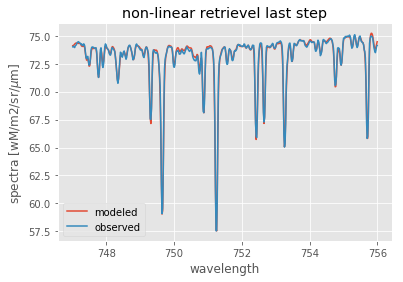

In [621]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

In [622]:
np.array(ma)[-1,:]

array([-1.13768223e-08,  9.99586804e-01,  3.05303545e+01,  1.11639861e-01,
        2.47894316e-02,  2.41620566e+02, -2.76943652e+00])

In [623]:
ma[-1]

array([-1.13768223e-08,  9.99586804e-01,  3.05303545e+01,  1.11639861e-01,
        2.47894316e-02,  2.41620566e+02, -2.76943652e+00])

In [624]:
spectra2 =spectra_[200,:,550]


In [625]:
ma,mb,mc = iterate_fit([0,1,40]+[0.133,0.3,233,0.06],mySetup,spectra2,n_itr=100,thrs=1e-6)

In [626]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [627]:
np.array(ma)[:,-1]

array([-2.41653353, -2.42703349, -2.42491426, -2.42351194, -2.42340482,
       -2.42355793, -2.42345686, -2.42252386, -2.42316415, -2.42195093,
       -2.42343923, -2.42233115, -2.42324509, -2.42208134, -2.42337654,
       -2.42222975, -2.42329378, -2.42216463, -2.42332823, -2.42219752,
       -2.42330927, -2.42218556, -2.42331593, -2.42218976, -2.42331359,
       -2.42218828, -2.42331442, -2.42218881, -2.42331413, -2.42218862,
       -2.42331423, -2.42218869, -2.42331419, -2.42218867, -2.42331421,
       -2.42218866, -2.42331421, -2.42218868, -2.4233142 , -2.42218866,
       -2.42331421, -2.42218867, -2.42331421, -2.42218867, -2.42331421,
       -2.42218866, -2.42331421, -2.42218868, -2.42331419, -2.42218866,
       -2.42331422, -2.42218868, -2.4233142 , -2.42218867, -2.4233142 ,
       -2.42218867, -2.4233142 , -2.42218867, -2.4233142 , -2.42218867,
       -2.42331421, -2.42218867, -2.4233142 , -2.42218868, -2.42331419,
       -2.42218866, -2.42331421, -2.42218867, -2.4233142 , -2.42

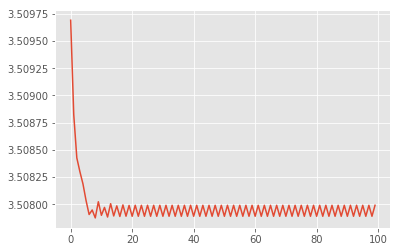

In [628]:
plt.plot(mc)

Text(0.5,1,'non-linear retrievel last step')

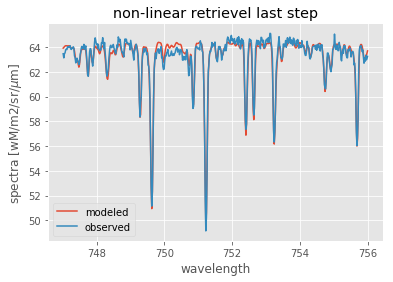

In [629]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')